#### Imports

In [41]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import helper.normalizer
from config import FEATURES_USED_BY_CLASSIFIER
import helper.normalizer as normalizer
import numpy as np
import matplotlib.pyplot as plt
import math

import importlib
importlib.reload(helper.normalizer)


<module 'helper.normalizer' from '/Users/levin/PycharmProjects/Code/helper/normalizer.py'>

#### Daten einlesen

In [42]:
df = pd.read_csv('output_isDigit.csv')
df = df[df['stopwords_removed'] == True]
df = df[df['author'] != 'ALL']
df = df[df['link_distance'] != '1']
df = df[df['fixed_token_count'] == df['fixed_token_count'].max()]

# Filter für Features, die in Klassifizierung mit einbezogen werden
features = FEATURES_USED_BY_CLASSIFIER

df = normalizer.normalize(df, features)

X = df[features]
y = df['author']

# print(X['betweenness_min'])
# print(df['assortativity_coefficient'])
# print(X[X.isna().any(axis=1)])

#### Klassifikatoren erstellen, trainieren und Genauigkeit auswerten

Testdaten-Anteil: 0.25
Unterschiedliche Aufteilungen der Daten: 400
Genauigkeit: 
    Durchschnitt: 0.2572058823529412
    Minimum: 0.0
    Maximum: 0.7647058823529411
    Standardabweichung: 0.10651353943534589
Insgesamt 68 Einträge im Dataframe.


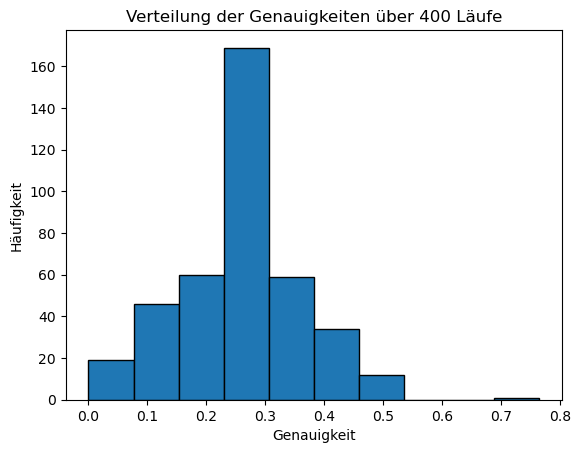

ValueError: [('powerlaw_xmin_value', -0.05441176470588236)] is not in list

In [43]:

# Je Split teilen wir die Daten auf
split_count = 4
n_repeats = 100

# Fold festlegen für Kreuzvalidierung
cv = RepeatedStratifiedKFold(n_splits=split_count, n_repeats=n_repeats, random_state=42)

classifier_list = [
    DummyClassifier(strategy='uniform'),
    DecisionTreeClassifier(), # Entscheidungsbaum
    KNeighborsClassifier(n_neighbors=5), # KNN-Algorithmus
    GaussianNB() # Naive-Bayes-Algorithmus
]

for classifier in classifier_list:

    # Bilden der Genauigkeitswerte
    accuracy_scores = cross_val_score(classifier, X, y, cv=cv)

    # Statistiken dazu ausgeben
    print(f'Testdaten-Anteil: {1 / split_count}')
    print(f'Unterschiedliche Aufteilungen der Daten: {len(accuracy_scores)}')
    print(f'Genauigkeit: ')
    print(f'    Durchschnitt: {np.mean(accuracy_scores)}')
    print(f'    Minimum: {min(accuracy_scores)}')
    print(f'    Maximum: {max(accuracy_scores)}')
    print(f'    Standardabweichung: {np.std(accuracy_scores)}')
    print(f'Insgesamt {len(df)} Einträge im Dataframe.')

    # Histogramm zu Genauigkeiten plotten
    plt.hist(accuracy_scores, bins=10, edgecolor='black')
    plt.xlabel('Genauigkeit')
    plt.ylabel('Häufigkeit')
    plt.title(f'Verteilung der Genauigkeiten über {len(accuracy_scores)} Läufe')
    plt.show()

    # Klassifikator auf alle verfügbaren Daten trainieren, damit Permutationswichtigkeit bestimmt werden kann.
    classifier.fit(X, y)

    # Bestimmung der Permutationswichtigkeit
    permutation_importance_list = permutation_importance(classifier, X, y, n_repeats=10)
    most_important_features = sorted(list(zip(features, permutation_importance_list.importances_mean)), key = lambda x: x[1])

    powerlaw_xmin_tuple = [tuple for tuple in most_important_features if tuple[0] == 'powerlaw_xmin_value']
    print(f'Platzierung von powerlaw_xmin_value: {most_important_features.index(powerlaw_xmin_tuple)}')

    print(f"Die zwei wichtigsten Metriken: {most_important_features}")
    print(f"\n\n")
